In [158]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join, exists
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, interactive, Dropdown

In [4]:
ls /glade/p/ral/nsap/rozoff/hfip/

ascii/                 realtime/       reforecast/
besttrack_predictors/  realtime_mslp/  reforecast_mslp/


In [5]:
best_track_path = "/glade/p/ral/nsap/rozoff/hfip/besttrack_predictors/"
atl_best_track = xr.open_dataset(join(best_track_path, "diag_2015_2017_adecks_atl_bug_corrected.nc"))

In [15]:
atl_best_track["vmax_bt"]

<xarray.DataArray 'vmax_bt' (time: 43, run: 1146)>
array([[30. , 35. , 40. , ..., 45. , 40. , 40. ],
       [32.5, 37.5, 40. , ..., 42.5, 40. ,  nan],
       [35. , 40. , 40. , ..., 40. , 40. ,  nan],
       ...,
       [30. , 25. , 25. , ...,  nan,  nan,  nan],
       [27.5, 25. , 25. , ...,  nan,  nan,  nan],
       [25. , 25. , 25. , ...,  nan,  nan,  nan]], dtype=float32)
Dimensions without coordinates: time, run
Attributes:
    long_name:  Best Track Vmax
    units:      kt

In [6]:
bt_vars = pd.Series(list(atl_best_track.variables.keys()))
m_vars = bt_vars[0:69]
for var in m_vars:
    print("{0:10s} {1:50s} {2:15s}".format(var, atl_best_track[var].attrs["long_name"], atl_best_track[var].attrs["units"]))

DATE       Forecast Run                                       YYYYMMDDHH     
STNAM      Storm Name                                         Name           
STNUM      Storm Number                                       number         
BASIN      Basin ID                                           Basin ID       
TIME       Forecast_Time                                      h              
LAT        Latitude                                           Deg N          
LON        Longitude                                          Deg E          
VMAX       Maximum_Wind_Speed                                 kt             
RMW        Radius_Maximum_Wind                                km             
MIN_SLP    Min_Sea_Lev_Pres                                   hPa            
SHR_MAG    Shear_Magnitude                                    kt             
SHR_HDG    Shear_Heading                                      Deg            
STM_SPD    Storm_Speed                                        kt

In [8]:
m_vars

0          DATE
1         STNAM
2         STNUM
3         BASIN
4          TIME
5           LAT
6           LON
7          VMAX
8           RMW
9       MIN_SLP
10      SHR_MAG
11      SHR_HDG
12      STM_SPD
13      STM_HDG
14          SST
15          TPW
16         LAND
17      TANG850
18      VORT850
19      DVRG200
20         RHLO
21         RHMD
22         RHHI
23        CAPE1
24        CAPE2
25        CAPE3
26       LHTFL1
27       LHTFL2
28       LHTFL3
29       SHTFL1
        ...    
39    TCOND7003
40    TCONDALL1
41    TCONDALL2
42    TCONDALL3
43        INST1
44        INST2
45        INST3
46          CP1
47          CP2
48          CP3
49    TCONDSYM1
50    TCONDSYM2
51    TCONDSYM3
52    INERTSYM1
53    INERTSYM2
54    INERTSYM3
55    COUPLSYM1
56    COUPLSYM2
57    COUPLSYM3
58       WALLA1
59       WALLA2
60       WALLA3
61        WSYM1
62        WSYM2
63        WSYM3
64        USFC1
65        USFC2
66        USFC3
67     USFCSYM1
68     USFCSYM2
Length: 69, dtype: objec

In [16]:
bt_frame = atl_best_track[m_vars.tolist() + ["vmax_bt"]].to_dataframe()

In [129]:
bt_frame["YEAR"] = bt_frame["DATE"].str[:4].astype(int)
bt_frame["valid_date"] = pd.DatetimeIndex(bt_frame["DATE"].str.decode("UTF-8") + "00") + pd.TimedeltaIndex(bt_frame["TIME"].values, unit="h")

In [32]:
bt_frame["STNAM"].unique()

array([b'invest    ', b'ana       ', b'alex      ', b'two       ',
       b'bonnie    ', b'bret      ', b'claudette ', b'three     ',
       b'colin     ', b'cindy     ', b'four      ', b'danielle  ',
       b'erika     ', b'earl      ', b'don       ', b'six       ',
       b'fred      ', b'fiona     ', b'emily     ', b'seven     ',
       b'grace     ', b'gaston    ', b'franklin  ', b'eight     ',
       b'henri     ', b'gert      ', b'nine      ', b'hermine   ',
       b'harvey    ', b'ian       ', b'ten       ', b'eleven    ',
       b'joaquin   ', b'julia     ', b'irma      ', b'twelve    ',
       b'kate      ', b'karl      ', b'jose      ', b'thirteen  ',
       b'lisa      ', b'katia     ', b'matthew   ', b'fourteen  ',
       b'lee       ', b'nicole    ', b'fifteen   ', b'maria     ',
       b'sixteen   ', b'otto      ', b'nate      ', b'seventeen ',
       b'ophelia   ', b'eighteen  ', b'philippe  ', b'nineteen  ',
       b'rina      '], dtype=object)

In [130]:
bt_frame.loc[bt_frame["STNAM"].str.strip() == b"harvey"]

DATE          STNAM  STNUM  BASIN  TIME        LAT  \
run time                                                                
452 0     b'2017081800'  b'harvey    '  b'09'  b'l '     0  13.000000   
    1     b'2017081800'  b'harvey    '  b'09'  b'l '     3  13.100000   
    2     b'2017081800'  b'harvey    '  b'09'  b'l '     6  13.100000   
    3     b'2017081800'  b'harvey    '  b'09'  b'l '     9  13.400000   
    4     b'2017081800'  b'harvey    '  b'09'  b'l '    12  13.400000   
    5     b'2017081800'  b'harvey    '  b'09'  b'l '    15  13.300000   
    6     b'2017081800'  b'harvey    '  b'09'  b'l '    18  13.500000   
    7     b'2017081800'  b'harvey    '  b'09'  b'l '    21  13.500000   
    8     b'2017081800'  b'harvey    '  b'09'  b'l '    24  14.000000   
    9     b'2017081800'  b'harvey    '  b'09'  b'l '    27  14.000000   
    10    b'2017081800'  b'harvey    '  b'09'  b'l '    30  13.700000   
    11    b'2017081800'  b'harvey    '  b'09'  b'l '    33  13.900000   
    12    b'2017081800'  b'harvey    '  b'09'  b'l '    36  13.900000   
    13    b'2017081800'  b'harvey    '  b'09'  b'l '    39  14.100000   
    14    b'2017081800'  b'harvey    '  b'09'  b'l '    42  14.200000   
    15    b'2017081800'  b'harvey    '  b'09'  b'l '    45  14.400000   
    16    b'2017081800'  b'harvey    '  b'09'  b'l '    48  14.400000   
    17    b'2017081800'  b'harvey    '  b'09'  b'l '    51  14.500000   
    18    b'2017081800'  b'harvey    '  b'09'  b'l '    54  14.400000   
    19    b'2017081800'  b'harvey    '  b'09'  b'l '    57  14.500000   
    20    b'2017081800'  b'harvey    '  b'09'  b'l '    60  14.100000   
    21    b'2017081800'  b'harvey    '  b'09'  b'l '    63  14.200000   
    22    b'2017081800'  b'harvey    '  b'09'  b'l '    66  14.400000   
    23    b'2017081800'  b'harvey    '  b'09'  b'l '    69  14.800000   
    24    b'2017081800'  b'harvey    '  b'09'  b'l '    72  15.000000   
    25    b'2017081800'  b'harvey    '  b'09'  b'l '    75  15.000000   
    26    b'2017081800'  b'harvey    '  b'09'  b'l '    78  15.000000   
    27    b'2017081800'  b'harvey    '  b'09'  b'l '    81  15.200000   
    28    b'2017081800'  b'harvey    '  b'09'  b'l '    84  15.500000   
    29    b'2017081800'  b'harvey    '  b'09'  b'l '    87  15.500000   
...                 ...            ...    ...    ...   ...        ...   
504 13    b'2017083100'  b'harvey    '  b'09'  b'l '    39  36.099998   
    14    b'2017083100'  b'harvey    '  b'09'  b'l '    42  36.299999   
    15    b'2017083100'  b'harvey    '  b'09'  b'l '    45  36.400002   
    16    b'2017083100'  b'harvey    '  b'09'  b'l '    48  36.599998   
    17    b'2017083100'  b'harvey    '  b'09'  b'l '    51  36.599998   
    18    b'2017083100'  b'harvey    '  b'09'  b'l '    54  37.000000   
    19    b'2017083100'  b'harvey    '  b'09'  b'l '    57  37.200001   
    20    b'2017083100'  b'harvey    '  b'09'  b'l '    60  37.500000   
    21    b'2017083100'  b'harvey    '  b'09'  b'l '    63  37.799999   
    22    b'2017083100'  b'harvey    '  b'09'  b'l '    66  38.000000   
    23    b'2017083100'  b'harvey    '  b'09'  b'l '    69  38.299999   
    24    b'2017083100'  b'harvey    '  b'09'  b'l '    72  38.400002   
    25    b'2017083100'  b'harvey    '  b'09'  b'l '    75  38.299999   
    26    b'2017083100'  b'harvey    '  b'09'  b'l '    78  38.400002   
    27    b'2017083100'  b'harvey    '  b'09'  b'l '    81  38.400002   
    28    b'2017083100'  b'harvey    '  b'09'  b'l '    84  38.500000   
    29    b'2017083100'  b'harvey    '  b'09'  b'l '    87  38.700001   
    30    b'2017083100'  b'harvey    '  b'09'  b'l '    90  38.299999   
    31    b'2017083100'  b'harvey    '  b'09'  b'l '    93        NaN   
    32    b'2017083100'  b'harvey    '  b'09'  b'l '    96        NaN   
    33    b'2017083100'  b'harvey    '  b'09'  b'l '    99        NaN   
    34    b'2017083100'  b'harvey    '  b'09'  b'l '   102        NaN   
    

In [22]:
bt_frame.loc[np.isnan(bt_frame["vmax_bt"]) & ~np.isnan(bt_frame["VMAX"])]["VMAX"].min()

6.0

In [145]:
variables = ["DATE", "STNAM", "STNUM", "BASIN", "TIME", "LAT", "LON", "VMAX"]
bt_frame = atl_best_track[variables].to_dataframe()

(array([3271., 5538., 4920., 4404., 3772., 3650., 4540., 6712., 5114.,
         685.]),
 array([  43.90999985,  139.51899986,  235.12799988,  330.73699989,
         426.34599991,  521.95499992,  617.56399994,  713.17299995,
         808.78199997,  904.39099998, 1000.        ]),
 <a list of 10 Patch objects>)

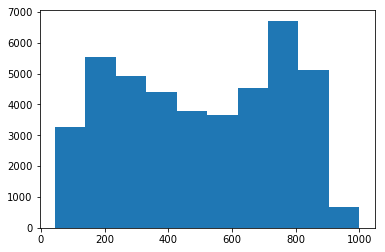

In [130]:
rmws = atl_best_track["INERTSYM1"].values.ravel()
plt.hist(rmws[~np.isnan(rmws)])

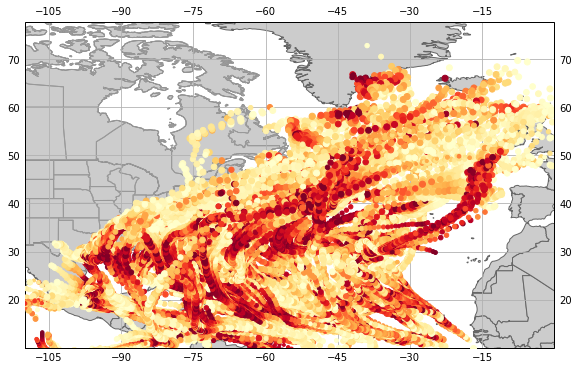

In [74]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
#ax.coastlines(resolution="50m", color="red")
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="0.8", edgecolor="0.4")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="0.6")
ax.add_feature(countries)
ax.add_feature(states)
ax.gridlines(draw_labels=True, )
ax.set_extent((-110, 0, 10, 70))
for run in atl_best_track.run:
    run_nans = np.isnan(atl_best_track["LON"][:, run])
    if np.any(run_nans):
        nan_start = np.where(run_nans)[0].min()
    else:
        nan_start = atl_best_track.dims["time"]
    if nan_start > 0:
        ax.scatter(atl_best_track["LON"][:nan_start, run], 
                   atl_best_track["LAT"][:nan_start, run], np.sqrt(atl_best_track["RMW"][:nan_start, run]) * 3, 
                   atl_best_track["VMAX"][:nan_start, run], cmap="YlOrRd", zorder=3)

In [78]:
lons

array([282.5, 282.4, 282.4, ...,   nan,   nan,   nan], dtype=float32)

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


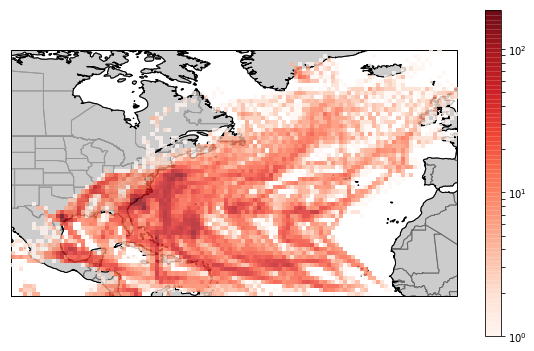

In [93]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
#ax.coastlines(resolution="50m", color="red")
countries = cfeature.NaturalEarthFeature("cultural", "admin_0_countries", "50m", facecolor="0.8", edgecolor="0.4")
states = cfeature.NaturalEarthFeature("cultural", "admin_1_states_provinces", "50m", facecolor="None", edgecolor="0.6")
ax.add_feature(countries)
ax.add_feature(states)
ax.coastlines(resolution="50m")
#ax.gridlines(draw_labels=True, )
ax.set_extent((-110, 0, 10, 70))
lons = atl_best_track["LON"].values.ravel()
lats = atl_best_track["LAT"].values.ravel()
plt.hist2d(lons[~np.isnan(lons)] - 360, lats[~np.isnan(lats)], 
           bins=(np.arange(-110, 0, 1), np.arange(10, 70.5, 1)), cmap="Reds", cmin=1, norm=LogNorm(), zorder=3, alpha=0.8)
plt.colorbar()

In [95]:
np.count_nonzero(~np.isnan(lons))

42951

In [155]:
def plot_runs(storm_name="harvey"):
    year = 2017
    plt.figure(figsize=(10, 6))
    bt_sub = bt_frame.loc[(bt_frame["YEAR"] == year) & (bt_frame["STNAM"].str.decode("UTF-8").str.strip() ==storm_name)]
    runs = bt_sub.index.get_level_values("run").unique()
    idx = pd.IndexSlice
    for run in runs[0:20]:
        plt.plot(pd.DatetimeIndex(bt_sub.loc[idx[run, :], "valid_date"]), bt_sub.loc[idx[run, :], "VMAX"], marker='o')
    #plt.xlim(bt_sub["valid_date"].min(), bt_sub["valid_date"].max())
    plt.show()


In [146]:
storm_names = bt_frame.loc[bt_frame["YEAR"] == 2017, "STNAM"].str.decode("utf-8").str.strip().unique().astype(str)

In [147]:
storm_names

array(['invest', 'two', 'bret', 'three', 'cindy', 'four', 'don', 'emily',
       'seven', 'franklin', 'eight', 'gert', 'nine', 'harvey', 'ten',
       'irma', 'jose', 'thirteen', 'katia', 'fourteen', 'lee', 'fifteen',
       'maria', 'sixteen', 'nate', 'seventeen', 'ophelia', 'eighteen',
       'philippe', 'nineteen', 'rina'], dtype='<U9')

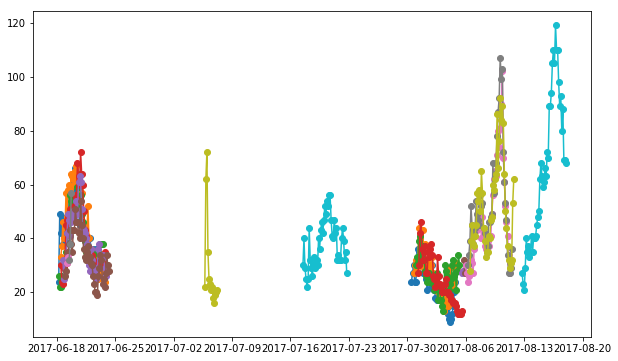

In [160]:
interactive_plot = interactive(plot_runs, storm_name=Dropdown(options=list(storm_names)))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [95]:
idx = pd.IndexSlice
year = 2017
storm_name = "harvey"
bt_sub = bt_frame.loc[(bt_frame["YEAR"] == year) & (bt_frame["STNAM"].str.decode("UTF-8").str.strip() ==storm_name)]


In [111]:
bt_sub.loc[idx[500, :], "VMAX"]

run  time
500  0       43.0
     1       40.0
     2       39.0
     3       37.0
     4       33.0
     5       35.0
     6       37.0
     7       35.0
     8       32.0
     9       29.0
     10      28.0
     11      30.0
     12      28.0
     13      29.0
     14      27.0
     15      34.0
     16      27.0
     17      34.0
     18      31.0
     19      29.0
     20      28.0
     21      31.0
     22      32.0
     23      30.0
     24      27.0
     25      29.0
     26      27.0
     27      25.0
     28      21.0
     29      18.0
     30      17.0
     31      18.0
     32      16.0
     33      12.0
     34      12.0
     35      14.0
     36      14.0
     37      12.0
     38      10.0
     39      11.0
     40       NaN
     41       NaN
     42       NaN
Name: VMAX, dtype: float32